# MNIST Project

In [394]:
import torch
from torch import nn, optim
import torchvision
from torchvision import datasets, transforms
import tqdm
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


## Data 불러오기

In [395]:
import scipy.ndimage
from PIL import Image as PILImage

In [396]:
train_data_mnist = datasets.MNIST('./datasets', train=True, download=True, transform=transforms.ToTensor())
test_data_mnist = datasets.MNIST('./datasets', train=True, download=True, transform=transforms.ToTensor())

In [193]:
mnist = train_data_mnist
x_sample = []
y_sample = []
for i, t in enumerate(mnist):
    X, y = t[0], t[1]
    X = X.numpy()
    X = (np.reshape(X, (28, 28, 1)) * 255).astype(np.uint8)
    x_sample.append(X)
    y_sample.append(y)

In [194]:
x_sample = np.array(x_sample)
y_sample = np.array(y_sample)
type(x_sample)

numpy.ndarray

In [195]:
print(len(x_sample))
print(x_sample.shape)

60000
(60000, 28, 28, 1)


In [196]:
print(len(y_sample))
print(y_sample.shape)

60000
(60000,)


In [708]:
lena = PILImage.open('photo/Road.jpeg')

In [709]:
def get_mnist_batch(batch_size=256, change_colors=True):
    
    # Select random batch (WxHxC)
    idx = np.random.choice(x_sample.shape[0], batch_size)
    batch_raw = x_sample[idx, :, :, 0].reshape((batch_size, 28, 28, 1))
    
#     print("y : ",y_train[idx])
    ans = y_sample[idx]
    # Resize (this is optional but results in a training set of larger images)
    batch_resized = np.asarray([scipy.ndimage.zoom(image, (1, 1, 1), order=1) for image in batch_raw])
    
    # Extend to RGB
    batch_rgb = np.concatenate([batch_resized, batch_resized, batch_resized], axis=3)
    
    # Convert the MNIST images to binary
    batch_binary = (batch_rgb > 0.5)
    
    # Create a new placeholder variable for our batch
    batch = np.zeros((batch_size, 28, 28, 3))
    
    for i in range(batch_size):
        # Take a random crop of the Lena image (background)
        x_c = np.random.randint(0, lena.size[0] - 28)
        y_c = np.random.randint(0, lena.size[1] - 28)
        image = lena.crop((x_c, y_c, x_c + 28, y_c + 28))
        # Conver the image to float between 0 and 1
        image = np.asarray(image) / 255.0

        if change_colors:
            # Change color distribution
            for j in range(3):
                image[:, :, j] = (image[:, :, j] + np.random.uniform(0, 1)) / 2.0

        # Invert the colors at the location of the number
        image[batch_binary[i]] = 1 - image[batch_binary[i]]
        
        batch[i] = image

    return batch, ans

In [710]:
count = 10000
examples, ans = get_mnist_batch(count)
# print(ans)
# plt.figure(figsize=(15,3))
# for i in range(count):
#     plt.subplot(2, count // 2, i+1)
#     plt.imshow(examples[i])  
#     plt.axis('off')
# plt.tight_layout()
# plt.show()

In [711]:
print((examples.shape))
print(ans.shape)

(10000, 28, 28, 3)
(10000,)


In [712]:
X_test = np.append(X_test,examples, axis=0)
y_test = np.append(y_test, ans, axis=0)

In [593]:
X_train = np.append(X_train, examples, axis=0)
y_train = np.append(y_train, ans, axis=0)

In [713]:
print(X_test.shape)
print(y_test.shape)

(20000, 28, 28, 3)
(20000,)


In [157]:
X_train = torch.as_tensor(examples, dtype=torch.float)
y_train = torch.as_tensor(ans)

In [162]:
count = 20000
X_test, y_test = get_mnist_batch(count)


In [164]:
X_test = torch.as_tensor(X_test, dtype=torch.float)
y_test = torch.as_tensor(y_test)

In [165]:
train_set = TensorDataset(X_train, y_train)
test_set =  TensorDataset(X_test, y_test)

In [166]:
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
test_loader = DataLoader(test_set, batch_size=128)

## Data Augmentation

In [796]:
def mnist_image_augment(mnist, scale=True, rotate=True, shear=True, colour=True, gaussian=True, invert=True):
    l = len(mnist)

    SC = np.random.normal(1, 0.3, size=l) # scale
    SH = np.random.normal(0, 1, size=(l, 3, 2)) # shear
    R = np.random.normal(0, 20, size=l) # rotate
    C = np.random.randint(22, size=l) # colour
    G = np.random.randint(30, size=l) # noise
    I = np.random.randint(2, size=l) # invert

    augmented = []

    for i, t in enumerate(mnist):
        X, y = t[0], t[1]
        X = X.numpy()
        X = (np.reshape(X, (28, 28, 1)) * 255).astype(np.uint8)

        if scale or rotate:
            if scale:
                sc = SC[i] if SC[i] >= 0 else -SC[i]
            else:
                sc = 1
            r = R[i] if rotate else 0

            M = cv2.getRotationMatrix2D((14, 14), r, sc)
            X = cv2.warpAffine(X, M, (28, 28))
        
        if shear:
            pts1 = np.float32([[4, 4], [4, 24], [24, 4]])
            pts2 = np.float32([[4+SH[i][0][0], 4+SH[i][0][1]], [4+SH[i][1][0], 24+SH[i][1][1]], [24+SH[i][2][0], 4+SH[i][2][1]]])
            
            M = cv2.getAffineTransform(pts1, pts2)
            X = cv2.warpAffine(X, M, (28, 28))

        if colour:
            X = cv2.applyColorMap(X, C[i])
        
        if gaussian:
            g = G[i]/100 if G[i] > 0 else - G[i]/100
            gauss = np.random.normal(0, g**0.5, X.shape)
            X = (X + gauss).astype(np.uint8)

        if invert:
            X = cv2.bitwise_not(X)

        recover = (np.reshape(X, (3, 28, 28)) / 255).astype(np.float32)   
        X = torch.from_numpy(recover)
        augmented.append([X, y])
    
    return augmented

In [797]:
augmented = mnist_image_augment(train_data_mnist)

In [802]:
# import csv
# with open('listfile.csv', 'w', newline='') as f: 
#     writer = csv.writer(f) 
#     writer.writerow(augmented) 

In [799]:
type(augmented)

list

In [725]:
idx = np.random.choice(60000, 10000)
idx

array([36071, 14288, 17037, ...,  6231, 23375, 59930])

In [726]:
test_ex = []
test_y = []

In [675]:
ex = []
ex_y = []

In [727]:
for i in idx:
    augment = augmented[i][0].numpy()
    augment = np.reshape(augment, (28, 28, 3))
    ans = augmented[i][1]
    
    test_ex = np.append(test_ex, augment)
    test_y = np.append(test_y, ans)

In [688]:
ex = ex.reshape(-1,28,28,3)
ex.shape

(10000, 28, 28, 3)

In [729]:
print(len(test_ex))
print(len(test_y))

23520000
10000


In [730]:
test_ex = test_ex.reshape(-1,28,28,3)
test_ex.shape

(10000, 28, 28, 3)

In [731]:
X_test = np.append(X_test,test_ex, axis=0)
y_test = np.append(y_test, test_y, axis=0)

In [691]:
X_train = np.append(X_train, ex, axis=0)
y_train = np.append(y_train, ex_y, axis=0)

In [597]:
test_data = mnist_image_augment(test_data_mnist)

In [598]:
def mnist_preview(mnist, augmented, n=5):
    for i in range(1000, 1000+n):
        origin = train_data_mnist[i][0].numpy()
        origin = (np.reshape(origin, (28, 28, 1)) * 255).astype(np.uint8)

        augment = augmented[i][0].numpy()
        augment = (np.reshape(augment, (28, 28, 3)) * 255).astype(np.uint8)
    
        plt.figure()
        f, axarr = plt.subplots(1,2) 

        axarr[0].imshow(origin, cmap='gray')
        axarr[1].imshow(augment)

<Figure size 432x288 with 0 Axes>

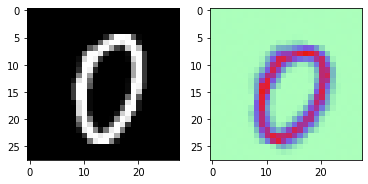

<Figure size 432x288 with 0 Axes>

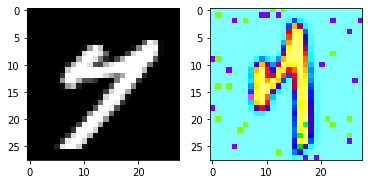

<Figure size 432x288 with 0 Axes>

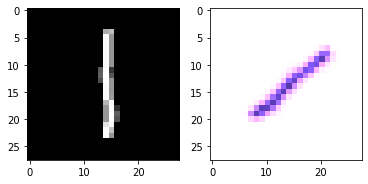

<Figure size 432x288 with 0 Axes>

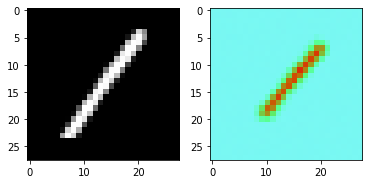

<Figure size 432x288 with 0 Axes>

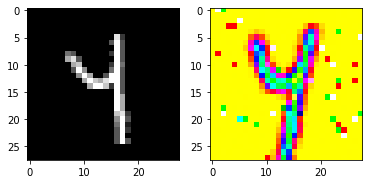

In [601]:
mnist_preview(train_data_mnist, augmented)

## Stanford

In [240]:
from torch.utils.data import Dataset
from scipy.io import loadmat

In [239]:
class CustomDataset(Dataset):
    def __init__(self, data, label):
        self.data = data
        self.label = label
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]

In [300]:
def swap_and_crop(x):
    data = np.transpose(x,(3,2,0,1))
    data = torch.Tensor(data)
    data = nn.functional.interpolate(data, size=(28,28))
    data = data.permute(0,2,3,1) 
    return data

def label_to_tensor(y):
    data = torch.Tensor(y)
    data = torch.squeeze(data)
    data[data == 10] = 0
    return data.type(torch.long)

In [301]:
train_file = loadmat('Project/train_32x32.mat')
test_file = loadmat('Project/test_32x32.mat')

In [302]:
svhn_train_x = swap_and_crop(train_file['X'])
svhn_train_y = label_to_tensor(train_file['y'])

svhn_test_x = swap_and_crop(test_file['X'])
svhn_test_y = label_to_tensor(test_file['y'])

In [307]:
svhn_train_x = svhn_train_x.numpy()
svhn_train_y = svhn_train_y.numpy()

In [735]:
svhn_test_x = svhn_test_x.numpy()
svhn_test_y = svhn_test_y.numpy()

In [736]:
svhn_test_x.shape

(26032, 28, 28, 3)

In [303]:
# train_data_SVHN = CustomDataset(svhn_train_x, svhn_train_y)
# test_data_SVHN = CustomDataset(svhn_test_x, svhn_test_y)

In [737]:
def choice(batch_size):
    idx = np.random.choice(svhn_test_x.shape[0], batch_size)
    
    x = svhn_test_x[idx, :, :, :]
    
    #     print("y : ",y_train[idx])
    y = svhn_test_y[idx]
    
    return x, y

In [738]:
x_data, y_data = choice(20000)

In [739]:
x_data.shape

(20000, 28, 28, 3)

In [740]:
y_data.shape

(20000,)

In [700]:
X_train = np.append(X_train, x_data, axis=0)

y_train = np.append(y_train, y_data, axis=0)

In [741]:
X_test = np.append(X_test, x_data, axis=0)

y_test = np.append(y_test, y_data, axis=0)

In [742]:
print(X_test.shape)

(50000, 28, 28, 3)


In [743]:
print(y_test.shape)

(50000,)


## Train & Test Data

In [560]:
X_train = np.empty((0,28,28,3), dtype=float)
y_train = np.empty(0, dtype=int)
X_test = np.empty((0,28,28,3), dtype=float)
y_test = np.empty(0, dtype=int)

In [744]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(100000, 28, 28, 3)
(100000,)
(50000, 28, 28, 3)
(50000,)


In [767]:
X_train = torch.as_tensor(X_train, dtype=torch.float)
y_train = torch.as_tensor(y_train, dtype = torch.long)
X_test = torch.as_tensor(X_test, dtype=torch.float)
y_test = torch.as_tensor(y_test, dtype = torch.long)

In [768]:
y_train.dtype

torch.int64

In [769]:
train_set = TensorDataset(X_train, y_train)
test_set =  TensorDataset(X_test, y_test)

In [770]:
learning_rate = 1e-3
batch_size = 128

In [771]:
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size)

## Model

In [772]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [773]:
def layer_block(in_f, out_f, *args, **kwargs):
    return nn.Sequential(
        nn.Conv2d(in_f, out_f, *args, **kwargs),
        nn.BatchNorm2d(out_f, eps=1e-05, momentum=0.1),
        nn.ReLU()
    )

In [781]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(self).__init__()
        self.keep_prob = 0.4

        channels_1 = 6
        channels_2 = 16

        self.layer1 = nn.Sequential(
            layer_block(3,32,kernel_size=5,padding=1),
            layer_block(32,32,kernel_size=5,padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.25)
        )
    
    
        self.layer2 = nn.Sequential(
            layer_block(32,64,kernel_size=3,padding=1),
            layer_block(64,64,kernel_size=3,padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.25)
        )
        
        
        self.fc3 = nn.Linear(6*6*64,256, bias=True)
        torch.nn.init.xavier_uniform_(self.fc3.weight)
        self.layer3 = nn.Sequential(
            self.fc3, 
            nn.ReLU(),
            nn.Dropout(p= 0.5))
        
        self.fc4 = nn.Linear(256,128,bias=True)
        nn.init.xavier_uniform_(self.fc4.weight)
        self.layer4 = nn.Sequential(
            self.fc4,
            nn.ReLU(),
            nn.Dropout(p=0.5))
        
        self.fc5 = nn.Linear(128,10,bias=True)
        nn.init.xavier_uniform_(self.fc5.weight)
        
    
    def forward(self, x):
        x = x.permute(0,3,1,2)
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        
        out = self.layer3(out)
        out = self.layer4(out)
        
        out = self.fc5(out)
        return out
        

In [782]:
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [787]:
history = []
costs = []
total_batch = len(train_loader)

## Training

In [788]:
for epoch in range(15):
    model.train()
    cost = 0
#     n_batches = 0
    for X, Y in tqdm.tqdm(train_loader):
        optimizer.zero_grad()
        y_hat = model(X)
    
        Y = Y.squeeze_()
#         Y = Y.long()
        loss = criterion(y_hat, Y)
        loss.backward()
        optimizer.step()
        
        cost += loss / total_batch
#         cost += loss.item()
#         n_batches += 1
        
#     cost /= n_batches
    print('[Epoch: {:>4}] cost = {:>9}'.format(epoch+1, cost))
    costs.append(cost)
    print("TEST")
    result = test(test_loader, model)
    history.append(result)

  0%|          | 1/391 [00:00<01:03,  6.14it/s]

[Epoch:    1] cost = 2.1529853343963623
TEST


  0%|          | 0/782 [00:00<?, ?it/s]

Accuracy: 0.27900001406669617


  0%|          | 1/391 [00:00<01:16,  5.12it/s]

[Epoch:    2] cost = 1.9890811443328857
TEST


  0%|          | 0/782 [00:00<?, ?it/s]

Accuracy: 0.3101400136947632


  0%|          | 1/391 [00:00<01:09,  5.61it/s]

[Epoch:    3] cost = 1.9116027355194092
TEST


  0%|          | 0/782 [00:00<?, ?it/s]

Accuracy: 0.36910000443458557


  0%|          | 1/391 [00:00<01:07,  5.81it/s]

[Epoch:    4] cost = 1.787636160850525
TEST


  0%|          | 0/782 [00:00<?, ?it/s]

Accuracy: 0.38947999477386475


  0%|          | 1/391 [00:00<01:06,  5.88it/s]

[Epoch:    5] cost = 1.6822404861450195
TEST


  0%|          | 0/782 [00:00<?, ?it/s]

Accuracy: 0.414000004529953


  0%|          | 1/391 [00:00<01:04,  6.01it/s]

[Epoch:    6] cost = 1.6239413022994995
TEST


  0%|          | 0/782 [00:00<?, ?it/s]

Accuracy: 0.42357999086380005


  0%|          | 1/391 [00:00<01:02,  6.26it/s]

[Epoch:    7] cost = 1.5927108526229858
TEST


  0%|          | 0/782 [00:00<?, ?it/s]

Accuracy: 0.4235599935054779


  0%|          | 1/391 [00:00<01:03,  6.10it/s]

[Epoch:    8] cost = 1.5680880546569824
TEST


  0%|          | 0/782 [00:00<?, ?it/s]

Accuracy: 0.4267599880695343


  0%|          | 1/391 [00:00<01:03,  6.10it/s]

[Epoch:    9] cost = 1.5527098178863525
TEST


  0%|          | 0/782 [00:00<?, ?it/s]

Accuracy: 0.42917999625205994


  0%|          | 1/391 [00:00<01:02,  6.27it/s]

[Epoch:   10] cost = 1.5389047861099243
TEST


  0%|          | 0/782 [00:00<?, ?it/s]

Accuracy: 0.42245998978614807


  0%|          | 1/391 [00:00<01:11,  5.43it/s]

[Epoch:   11] cost = 1.5292370319366455
TEST


  0%|          | 0/782 [00:00<?, ?it/s]

Accuracy: 0.43171998858451843


  0%|          | 1/391 [00:00<01:08,  5.68it/s]

[Epoch:   12] cost = 1.524212121963501
TEST


  0%|          | 0/782 [00:00<?, ?it/s]

Accuracy: 0.43233999609947205


  0%|          | 1/391 [00:00<01:06,  5.86it/s]

[Epoch:   13] cost = 1.5134129524230957
TEST


  0%|          | 0/782 [00:00<?, ?it/s]

Accuracy: 0.43320000171661377


  0%|          | 1/391 [00:00<01:05,  5.97it/s]

[Epoch:   14] cost = 1.5086474418640137
TEST


  0%|          | 0/782 [00:00<?, ?it/s]

Accuracy: 0.43064001202583313


  0%|          | 1/391 [00:00<01:07,  5.76it/s]

[Epoch:   15] cost = 1.5057748556137085
TEST


100%|██████████| 391/391 [01:14<00:00,  5.22it/s]

Accuracy: 0.42621999979019165


## Test

In [779]:
def test(data_loader, model):
    model.eval()
    n_predict = 0
    n_correct = 0
    with torch.no_grad():
        for X,Y in tqdm.tqdm(data_loader):
            y_hat = model(X)
            y_hat.argmax()
            
            _, predicted = torch.max(y_hat,1)
            
            n_predict += len(predicted)
            n_correct += (Y==predicted).sum()
            
    accuracy = n_correct/n_predict
    print(f"Accuracy: {accuracy}")
    return accuracy

In [789]:
test(test_loader, model)

100%|██████████| 391/391 [01:01<00:00,  6.38it/s]

Accuracy: 0.42621999979019165


tensor(0.4262)

In [807]:
import torchsummary
torchsummary.summary(model, (28,28,3),device='cpu')


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]           2,432
       BatchNorm2d-2           [-1, 32, 26, 26]              64
              ReLU-3           [-1, 32, 26, 26]               0
            Conv2d-4           [-1, 32, 24, 24]          25,632
       BatchNorm2d-5           [-1, 32, 24, 24]              64
              ReLU-6           [-1, 32, 24, 24]               0
         MaxPool2d-7           [-1, 32, 12, 12]               0
           Dropout-8           [-1, 32, 12, 12]               0
            Conv2d-9           [-1, 64, 12, 12]          18,496
      BatchNorm2d-10           [-1, 64, 12, 12]             128
             ReLU-11           [-1, 64, 12, 12]               0
           Conv2d-12           [-1, 64, 12, 12]          36,928
      BatchNorm2d-13           [-1, 64, 12, 12]             128
             ReLU-14           [-1, 64,

In [ ]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64, eps=1e-05, momentum=0.1),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64, eps=1e-05, momentum=0.1),
            nn.ReLU(),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64, eps=1e-05, momentum=0.1),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64, eps=1e-05, momentum=0.1),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.25),
        )
       
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64, eps=1e-05, momentum=0.1),
            nn.ReLU(),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64, eps=1e-05, momentum=0.1),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.25),
        )
        
        self.fc1 = nn.Sequential(
            nn.Dropout(0.25),
            nn.Linear(7 * 7 * 64, 256),
            nn.BatchNorm1d(num_features=256, eps=1e-05, momentum=0.1),
            nn.ReLU(),
            nn.Dropout(0.25),
        )
        
        self.fc2 = nn.Sequential(
            nn.Dropout(0.25),
            nn.Linear(256, 10),
        )
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        
        # Flatten the 3 last dimensions (channels, width, height) to one
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x

# move the net to gpu if available
net = Net().to(device)

In [8]:
# train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle=True)
# dev_loader = torch.utils.data.DataLoader(val_set, batch_size = batch_size)
# test_loader = torch.utils.data.DataLoader(test_data_mnist, batch_size = batch_size)

In [ ]:
#keras
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [ ]:

model = Sequential()
#
model.add(Conv2D(filters = 8, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
#
model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))
# fully connected
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [ ]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64, eps=1e-05, momentum=0.1),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64, eps=1e-05, momentum=0.1),
            nn.ReLU(),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64, eps=1e-05, momentum=0.1),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64, eps=1e-05, momentum=0.1),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.25),
        )
       
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64, eps=1e-05, momentum=0.1),
            nn.ReLU(),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64, eps=1e-05, momentum=0.1),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.25),
        )
        
        self.fc1 = nn.Sequential(
            nn.Dropout(0.25),
            nn.Linear(7 * 7 * 64, 256),
            nn.BatchNorm1d(num_features=256, eps=1e-05, momentum=0.1),
            nn.ReLU(),
            nn.Dropout(0.25),
        )
        
        self.fc2 = nn.Sequential(
            nn.Dropout(0.25),
            nn.Linear(256, 10),
        )
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        
        # Flatten the 3 last dimensions (channels, width, height) to one
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x

# move the net to gpu if available
net = Net().to(device)

In [793]:
torch.save(model.state_dict(), 'model.pt')